In [42]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import optuna as opt
import numpy as np
import os
import plotly
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from optuna.integration import XGBoostPruningCallback
import optuna.visualization as vis
import shap


In [29]:
df = pd.read_csv("c:/Users/samud/Documents/Python_Learning/Asteroids/neo.csv/neo.csv")
df.dtypes

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object

In [30]:
df.select_dtypes(include =["float", "int", "bool"])

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,sentry_object,absolute_magnitude,hazardous
0,2162635,1.198271,2.679415,13569.249224,5.483974e+07,False,16.73,False
1,2277475,0.265800,0.594347,73588.726663,6.143813e+07,False,20.00,True
2,2512244,0.722030,1.614507,114258.692129,4.979872e+07,False,17.83,False
3,3596030,0.096506,0.215794,24764.303138,2.543497e+07,False,22.20,False
4,3667127,0.255009,0.570217,42737.733765,4.627557e+07,False,20.09,True
...,...,...,...,...,...,...,...,...
90831,3763337,0.026580,0.059435,52078.886692,1.230039e+07,False,25.00,False
90832,3837603,0.016771,0.037501,46114.605073,5.432121e+07,False,26.00,False
90833,54017201,0.031956,0.071456,7566.807732,2.840077e+07,False,24.60,False
90834,54115824,0.007321,0.016370,69199.154484,6.869206e+07,False,27.80,False


In [31]:
#for cl in df.select_dtypes(include =["float", "int"]).columns:
 #   df.hist(column= cl)

In [32]:
## These two columns are equal along all dataset -> They are not reliable features as predictors
df = df.drop(columns=['sentry_object','orbiting_body','name','id'])
df = df.drop_duplicates()
df['hazardous'] = df['hazardous'].astype(int)

In [33]:
# Detected Imbalanced dataset
df['hazardous'].value_counts()

hazardous
0    81996
1     8833
Name: count, dtype: int64

In [34]:
X = df.drop(columns='hazardous')
Y = df['hazardous']


In [53]:
def objective(trial):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify = Y, random_state = 42)
    train = xgb.DMatrix(X_train, Y_train)
    test = xgb.DMatrix(X_test, Y_test)
    trial.set_user_attr('X_train', X_train)
    trial.set_user_attr('X_test', X_test)
    trial.set_user_attr('Y_train', Y_train)
    trial.set_user_attr('Y_test', Y_test)


    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_float("eta", 1e-8, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }

    # Add a callback for pruning.
    pruning_callback = opt.integration.XGBoostPruningCallback(trial, "validation-auc")

    # Best Model
    bst = xgb.train(param, train, evals=[(test, "validation")])
    trial.set_user_attr("model", bst)
    preds = bst.predict(test)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(Y_test, pred_labels)
    return auc

In [54]:
# Step 10: Create the Optuna study to optimize the objective function
study = opt.create_study(direction="maximize")  # Maximize AUC

# Step 11: Start the optimization process with a specified number of trials
study.optimize(objective, n_trials=100)

# Step 12: Print the best trial's parameters
print("Best trial:")
print(f"AUC: {study.best_trial.value}")
print("Best parameters: ", study.best_trial.params)

[I 2024-12-23 12:25:55,210] A new study created in memory with name: no-name-3c8f099b-54de-4e50-90d8-bae647f99a56


[0]	validation-auc:0.90955
[1]	validation-auc:0.91593
[2]	validation-auc:0.91679
[3]	validation-auc:0.91672
[4]	validation-auc:0.91688
[5]	validation-auc:0.91731
[6]	validation-auc:0.91829
[7]	validation-auc:0.91842
[8]	validation-auc:0.91845
[9]	validation-auc:0.91951


[I 2024-12-23 12:25:55,530] Trial 0 finished with value: 0.5758898435184858 and parameters: {'lambda': 0.5234079215137057, 'alpha': 0.6296013336476731, 'max_depth': 8, 'eta': 0.35345414999382113, 'gamma': 0.1132327975057465, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5758898435184858.


[0]	validation-auc:0.89705
[1]	validation-auc:0.90771
[2]	validation-auc:0.90803
[3]	validation-auc:0.90900
[4]	validation-auc:0.91299
[5]	validation-auc:0.91427
[6]	validation-auc:0.91455
[7]	validation-auc:0.91445
[8]	validation-auc:0.91437
[9]	validation-auc:0.91458


[I 2024-12-23 12:25:55,813] Trial 1 finished with value: 0.5679630657838571 and parameters: {'lambda': 0.10656648142196377, 'alpha': 0.18745102385525525, 'max_depth': 3, 'eta': 0.5122896157766605, 'gamma': 0.8341984506412143, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5758898435184858.


[0]	validation-auc:0.89705
[1]	validation-auc:0.90140
[2]	validation-auc:0.90414
[3]	validation-auc:0.90777
[4]	validation-auc:0.90769
[5]	validation-auc:0.90887
[6]	validation-auc:0.90874
[7]	validation-auc:0.90874
[8]	validation-auc:0.90976
[9]	validation-auc:0.91001


[I 2024-12-23 12:25:56,098] Trial 2 finished with value: 0.5667006867128185 and parameters: {'lambda': 0.5538830546560355, 'alpha': 0.8205657926187048, 'max_depth': 3, 'eta': 0.20627583054045817, 'gamma': 0.2597042930500345, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5758898435184858.


[0]	validation-auc:0.91031
[1]	validation-auc:0.91378
[2]	validation-auc:0.91357
[3]	validation-auc:0.91388
[4]	validation-auc:0.91480
[5]	validation-auc:0.91610
[6]	validation-auc:0.91712
[7]	validation-auc:0.91749
[8]	validation-auc:0.91763
[9]	validation-auc:0.91780


[I 2024-12-23 12:25:56,535] Trial 3 finished with value: 0.5733565268742318 and parameters: {'lambda': 0.8628271684050582, 'alpha': 0.46690379755482986, 'max_depth': 9, 'eta': 0.22784584694161178, 'gamma': 0.8190124337117629, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5758898435184858.


[0]	validation-auc:0.90408
[1]	validation-auc:0.90891
[2]	validation-auc:0.91301
[3]	validation-auc:0.91382
[4]	validation-auc:0.91414
[5]	validation-auc:0.91530
[6]	validation-auc:0.91588
[7]	validation-auc:0.91553
[8]	validation-auc:0.91606
[9]	validation-auc:0.91868


[I 2024-12-23 12:25:56,796] Trial 4 finished with value: 0.5860584139169804 and parameters: {'lambda': 0.3104662721756135, 'alpha': 0.4811872734596847, 'max_depth': 4, 'eta': 0.9353732848270632, 'gamma': 0.09699354471047465, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.5860584139169804.


[0]	validation-auc:0.91005
[1]	validation-auc:0.91242
[2]	validation-auc:0.91367
[3]	validation-auc:0.91430
[4]	validation-auc:0.91529
[5]	validation-auc:0.91726
[6]	validation-auc:0.91728
[7]	validation-auc:0.91744
[8]	validation-auc:0.91773
[9]	validation-auc:0.91878


[I 2024-12-23 12:25:57,245] Trial 5 finished with value: 0.5686985620646531 and parameters: {'lambda': 0.800734623756232, 'alpha': 0.2544439610083114, 'max_depth': 9, 'eta': 0.20328766410335877, 'gamma': 0.2902477583632217, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.5860584139169804.


[0]	validation-auc:0.87133
[1]	validation-auc:0.87361
[2]	validation-auc:0.87361
[3]	validation-auc:0.89090
[4]	validation-auc:0.89177
[5]	validation-auc:0.89948
[6]	validation-auc:0.90007
[7]	validation-auc:0.90513
[8]	validation-auc:0.90529
[9]	validation-auc:0.90533


[I 2024-12-23 12:25:57,482] Trial 6 finished with value: 0.5805173186640605 and parameters: {'lambda': 0.9300662724782796, 'alpha': 0.9977560338835869, 'max_depth': 1, 'eta': 0.9644128490818932, 'gamma': 0.7721716733093076, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.5860584139169804.


[0]	validation-auc:0.90851
[1]	validation-auc:0.91205
[2]	validation-auc:0.91290
[3]	validation-auc:0.91487
[4]	validation-auc:0.91564
[5]	validation-auc:0.91538
[6]	validation-auc:0.91588
[7]	validation-auc:0.91567
[8]	validation-auc:0.91739
[9]	validation-auc:0.91816


[I 2024-12-23 12:25:57,729] Trial 7 finished with value: 0.6022350528434018 and parameters: {'lambda': 0.8577331698197359, 'alpha': 0.15256455236637667, 'max_depth': 6, 'eta': 0.7419005338823139, 'gamma': 0.14111618246263596, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.6022350528434018.


[0]	validation-auc:0.90408
[1]	validation-auc:0.90898
[2]	validation-auc:0.91011
[3]	validation-auc:0.91169
[4]	validation-auc:0.91387
[5]	validation-auc:0.91398
[6]	validation-auc:0.91530
[7]	validation-auc:0.91575
[8]	validation-auc:0.91601
[9]	validation-auc:0.91636


[I 2024-12-23 12:25:57,971] Trial 8 finished with value: 0.5676801003056455 and parameters: {'lambda': 0.5497308157773164, 'alpha': 0.14697597356137454, 'max_depth': 4, 'eta': 0.5145374669931873, 'gamma': 0.6557858193507905, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.6022350528434018.


[0]	validation-auc:0.90408
[1]	validation-auc:0.90426
[2]	validation-auc:0.90411
[3]	validation-auc:0.90781
[4]	validation-auc:0.90793
[5]	validation-auc:0.90792
[6]	validation-auc:0.90795
[7]	validation-auc:0.90818
[8]	validation-auc:0.90818
[9]	validation-auc:0.90809


[I 2024-12-23 12:25:58,199] Trial 9 finished with value: 0.5439596766169952 and parameters: {'lambda': 0.518964230766399, 'alpha': 0.9746117014733371, 'max_depth': 4, 'eta': 0.08068419544904348, 'gamma': 0.6083589603471239, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.6022350528434018.


[0]	validation-auc:0.90870
[1]	validation-auc:0.91099
[2]	validation-auc:0.91175
[3]	validation-auc:0.91417
[4]	validation-auc:0.91355
[5]	validation-auc:0.91419
[6]	validation-auc:0.91534
[7]	validation-auc:0.91813
[8]	validation-auc:0.91799
[9]	validation-auc:0.91882


[I 2024-12-23 12:25:58,501] Trial 10 finished with value: 0.5996664323776696 and parameters: {'lambda': 0.7137121097276284, 'alpha': 0.00809794687839907, 'max_depth': 7, 'eta': 0.7230466772579922, 'gamma': 0.3970130941020609, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.6022350528434018.


[0]	validation-auc:0.90847
[1]	validation-auc:0.91064
[2]	validation-auc:0.91232
[3]	validation-auc:0.91340
[4]	validation-auc:0.91382
[5]	validation-auc:0.91463
[6]	validation-auc:0.91667
[7]	validation-auc:0.91716
[8]	validation-auc:0.91867
[9]	validation-auc:0.92019


[I 2024-12-23 12:25:58,793] Trial 11 finished with value: 0.609287258636866 and parameters: {'lambda': 0.7371218032838497, 'alpha': 0.009434277865427904, 'max_depth': 7, 'eta': 0.7377687651776326, 'gamma': 0.34417520540434077, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.609287258636866.


[0]	validation-auc:0.90854
[1]	validation-auc:0.91102
[2]	validation-auc:0.91228
[3]	validation-auc:0.91448
[4]	validation-auc:0.91509
[5]	validation-auc:0.91420
[6]	validation-auc:0.91471
[7]	validation-auc:0.91543
[8]	validation-auc:0.91684
[9]	validation-auc:0.91755


[I 2024-12-23 12:25:59,083] Trial 12 finished with value: 0.6010373974450731 and parameters: {'lambda': 0.7168243938943212, 'alpha': 0.0060503162060951965, 'max_depth': 6, 'eta': 0.7331940466609033, 'gamma': 0.44773547202734665, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.609287258636866.


[0]	validation-auc:0.90836
[1]	validation-auc:0.91227
[2]	validation-auc:0.91286
[3]	validation-auc:0.91480
[4]	validation-auc:0.91490
[5]	validation-auc:0.91520
[6]	validation-auc:0.91587
[7]	validation-auc:0.91632
[8]	validation-auc:0.91807
[9]	validation-auc:0.91930


[I 2024-12-23 12:25:59,376] Trial 13 finished with value: 0.5982820946506152 and parameters: {'lambda': 0.9632375397298005, 'alpha': 0.3301138243709125, 'max_depth': 6, 'eta': 0.7440592472288624, 'gamma': 0.041903133436818854, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.609287258636866.


[0]	validation-auc:0.90837
[1]	validation-auc:0.91155
[2]	validation-auc:0.91347
[3]	validation-auc:0.91347
[4]	validation-auc:0.91506
[5]	validation-auc:0.91683
[6]	validation-auc:0.91715
[7]	validation-auc:0.92038
[8]	validation-auc:0.92072
[9]	validation-auc:0.92089


[I 2024-12-23 12:25:59,668] Trial 14 finished with value: 0.6142404917715351 and parameters: {'lambda': 0.700310760474521, 'alpha': 0.08298968894259248, 'max_depth': 7, 'eta': 0.8336657433824793, 'gamma': 0.23634781387739, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 0.6142404917715351.


[0]	validation-auc:0.90849
[1]	validation-auc:0.91161
[2]	validation-auc:0.91294
[3]	validation-auc:0.91561
[4]	validation-auc:0.91984
[5]	validation-auc:0.92043
[6]	validation-auc:0.92047
[7]	validation-auc:0.92026
[8]	validation-auc:0.92017
[9]	validation-auc:0.92036


[I 2024-12-23 12:25:59,967] Trial 15 finished with value: 0.6108839541991756 and parameters: {'lambda': 0.6843916849880752, 'alpha': 0.34768262023870244, 'max_depth': 7, 'eta': 0.8669083644086256, 'gamma': 0.2956126019397145, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 0.6142404917715351.


[0]	validation-auc:0.90968
[1]	validation-auc:0.90985
[2]	validation-auc:0.91241
[3]	validation-auc:0.91903
[4]	validation-auc:0.91949
[5]	validation-auc:0.91959
[6]	validation-auc:0.91997
[7]	validation-auc:0.91982
[8]	validation-auc:0.91989
[9]	validation-auc:0.91975


[I 2024-12-23 12:26:00,268] Trial 16 finished with value: 0.6247139588100687 and parameters: {'lambda': 0.32708830682345696, 'alpha': 0.3770592693185774, 'max_depth': 8, 'eta': 0.8755248677515917, 'gamma': 0.9887699377384187, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.6247139588100687.


[0]	validation-auc:0.91044
[1]	validation-auc:0.91165
[2]	validation-auc:0.91468
[3]	validation-auc:0.91685
[4]	validation-auc:0.91898
[5]	validation-auc:0.92014
[6]	validation-auc:0.91936
[7]	validation-auc:0.91991
[8]	validation-auc:0.91988
[9]	validation-auc:0.91965


[I 2024-12-23 12:26:00,579] Trial 17 finished with value: 0.6196366273938398 and parameters: {'lambda': 0.31696115706923944, 'alpha': 0.7220942439196338, 'max_depth': 9, 'eta': 0.855491048654996, 'gamma': 0.5645154458953369, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.6247139588100687.


[0]	validation-auc:0.91014
[1]	validation-auc:0.91219
[2]	validation-auc:0.91291
[3]	validation-auc:0.91313
[4]	validation-auc:0.91615
[5]	validation-auc:0.91916
[6]	validation-auc:0.91890
[7]	validation-auc:0.92020
[8]	validation-auc:0.91999
[9]	validation-auc:0.92039


[I 2024-12-23 12:26:00,949] Trial 18 finished with value: 0.6144844090835663 and parameters: {'lambda': 0.30893441936570704, 'alpha': 0.6522389404221521, 'max_depth': 9, 'eta': 0.6038978343602733, 'gamma': 0.910575197819546, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.6247139588100687.


[0]	validation-auc:0.90977
[1]	validation-auc:0.90860
[2]	validation-auc:0.91106
[3]	validation-auc:0.91282
[4]	validation-auc:0.91875
[5]	validation-auc:0.92040
[6]	validation-auc:0.92047
[7]	validation-auc:0.92124
[8]	validation-auc:0.92136
[9]	validation-auc:0.92076


[I 2024-12-23 12:26:01,246] Trial 19 finished with value: 0.6387868109202209 and parameters: {'lambda': 0.2929596364046604, 'alpha': 0.6374626891373627, 'max_depth': 8, 'eta': 0.9759616817846894, 'gamma': 0.561685204249543, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91004
[1]	validation-auc:0.90990
[2]	validation-auc:0.91285
[3]	validation-auc:0.91515
[4]	validation-auc:0.91687
[5]	validation-auc:0.91788
[6]	validation-auc:0.91724
[7]	validation-auc:0.91769
[8]	validation-auc:0.91943
[9]	validation-auc:0.91945


[I 2024-12-23 12:26:01,708] Trial 20 finished with value: 0.6274510747874015 and parameters: {'lambda': 0.15059847699908663, 'alpha': 0.5767010551473443, 'max_depth': 8, 'eta': 0.9946927609442008, 'gamma': 0.9585986124634154, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91000
[1]	validation-auc:0.91013
[2]	validation-auc:0.91301
[3]	validation-auc:0.91525
[4]	validation-auc:0.91736
[5]	validation-auc:0.91853
[6]	validation-auc:0.91872
[7]	validation-auc:0.91856
[8]	validation-auc:0.91858
[9]	validation-auc:0.91885


[I 2024-12-23 12:26:02,165] Trial 21 finished with value: 0.6192012135956086 and parameters: {'lambda': 0.13402059579682968, 'alpha': 0.5537889894740772, 'max_depth': 8, 'eta': 0.9922908208744007, 'gamma': 0.9697953717629837, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90944
[1]	validation-auc:0.90955
[2]	validation-auc:0.91092
[3]	validation-auc:0.91284
[4]	validation-auc:0.91525
[5]	validation-auc:0.91524
[6]	validation-auc:0.91663
[7]	validation-auc:0.92011
[8]	validation-auc:0.91927
[9]	validation-auc:0.91931


[I 2024-12-23 12:26:02,891] Trial 22 finished with value: 0.6194938073887688 and parameters: {'lambda': 0.2077575038575475, 'alpha': 0.8018673121501257, 'max_depth': 8, 'eta': 0.8963017367207335, 'gamma': 0.7079331926505155, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90981
[1]	validation-auc:0.90853
[2]	validation-auc:0.91306
[3]	validation-auc:0.91482
[4]	validation-auc:0.91671
[5]	validation-auc:0.91737
[6]	validation-auc:0.91757
[7]	validation-auc:0.91712
[8]	validation-auc:0.91676
[9]	validation-auc:0.91724


[I 2024-12-23 12:26:03,412] Trial 23 finished with value: 0.6302416814033376 and parameters: {'lambda': 0.399875193887712, 'alpha': 0.4056370311167888, 'max_depth': 8, 'eta': 0.9933407854093702, 'gamma': 0.9938639220707756, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90780
[1]	validation-auc:0.91109
[2]	validation-auc:0.91212
[3]	validation-auc:0.91240
[4]	validation-auc:0.91662
[5]	validation-auc:0.91732
[6]	validation-auc:0.91733
[7]	validation-auc:0.91894
[8]	validation-auc:0.91872
[9]	validation-auc:0.91874


[I 2024-12-23 12:26:03,822] Trial 24 finished with value: 0.5887709242005557 and parameters: {'lambda': 0.3908224318566383, 'alpha': 0.5731448787132031, 'max_depth': 5, 'eta': 0.6339806515560914, 'gamma': 0.8869065464666456, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90956
[1]	validation-auc:0.90816
[2]	validation-auc:0.91398
[3]	validation-auc:0.91439
[4]	validation-auc:0.91552
[5]	validation-auc:0.91909
[6]	validation-auc:0.91864
[7]	validation-auc:0.91786
[8]	validation-auc:0.91806
[9]	validation-auc:0.91672


[I 2024-12-23 12:26:04,443] Trial 25 finished with value: 0.6308113567044632 and parameters: {'lambda': 0.014201631471387977, 'alpha': 0.42581738597327795, 'max_depth': 8, 'eta': 0.982936790794522, 'gamma': 0.5340929025451181, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90827
[1]	validation-auc:0.91047
[2]	validation-auc:0.91124
[3]	validation-auc:0.91333
[4]	validation-auc:0.91413
[5]	validation-auc:0.91446
[6]	validation-auc:0.91742
[7]	validation-auc:0.91744
[8]	validation-auc:0.91787
[9]	validation-auc:0.91850


[I 2024-12-23 12:26:04,927] Trial 26 finished with value: 0.6009325557934105 and parameters: {'lambda': 0.0068504817151767705, 'alpha': 0.40783823902049826, 'max_depth': 6, 'eta': 0.790736101035002, 'gamma': 0.499046376641809, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90843
[1]	validation-auc:0.91217
[2]	validation-auc:0.91358
[3]	validation-auc:0.91461
[4]	validation-auc:0.91729
[5]	validation-auc:0.91750
[6]	validation-auc:0.91767
[7]	validation-auc:0.91884
[8]	validation-auc:0.91922
[9]	validation-auc:0.91923


[I 2024-12-23 12:26:05,479] Trial 27 finished with value: 0.5846264695215689 and parameters: {'lambda': 0.4327574503293968, 'alpha': 0.43557407044032104, 'max_depth': 7, 'eta': 0.6033139500263331, 'gamma': 0.5498893825593215, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.87133
[1]	validation-auc:0.87217
[2]	validation-auc:0.87361
[3]	validation-auc:0.87361
[4]	validation-auc:0.87361
[5]	validation-auc:0.87361
[6]	validation-auc:0.87361
[7]	validation-auc:0.89090
[8]	validation-auc:0.89177
[9]	validation-auc:0.89775


[I 2024-12-23 12:26:05,920] Trial 28 finished with value: 0.5 and parameters: {'lambda': 0.05464090149285948, 'alpha': 0.27810901428601587, 'max_depth': 1, 'eta': 0.40271652937893343, 'gamma': 0.6898364645440613, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90969
[1]	validation-auc:0.91085
[2]	validation-auc:0.91161
[3]	validation-auc:0.91458
[4]	validation-auc:0.91694
[5]	validation-auc:0.91800
[6]	validation-auc:0.91909
[7]	validation-auc:0.91863
[8]	validation-auc:0.91880
[9]	validation-auc:0.91865


[I 2024-12-23 12:26:06,469] Trial 29 finished with value: 0.6198768003611688 and parameters: {'lambda': 0.2184148431631, 'alpha': 0.6529479940547793, 'max_depth': 8, 'eta': 0.9276372235442553, 'gamma': 0.42355450333347944, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91033
[1]	validation-auc:0.91264
[2]	validation-auc:0.91341
[3]	validation-auc:0.91353
[4]	validation-auc:0.91664
[5]	validation-auc:0.91675
[6]	validation-auc:0.91710
[7]	validation-auc:0.91825
[8]	validation-auc:0.92008
[9]	validation-auc:0.92004


[I 2024-12-23 12:26:07,031] Trial 30 finished with value: 0.6213012560671757 and parameters: {'lambda': 0.43505457768382017, 'alpha': 0.5180309073561262, 'max_depth': 9, 'eta': 0.6633036902314964, 'gamma': 0.7380790045734248, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90965
[1]	validation-auc:0.90999
[2]	validation-auc:0.91361
[3]	validation-auc:0.91497
[4]	validation-auc:0.91527
[5]	validation-auc:0.91807
[6]	validation-auc:0.91850
[7]	validation-auc:0.91851
[8]	validation-auc:0.91873
[9]	validation-auc:0.91951


[I 2024-12-23 12:26:07,536] Trial 31 finished with value: 0.6344021832739052 and parameters: {'lambda': 0.20954095332045303, 'alpha': 0.5807684844431193, 'max_depth': 8, 'eta': 0.9903256316753943, 'gamma': 0.928527364089519, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90970
[1]	validation-auc:0.90936
[2]	validation-auc:0.91148
[3]	validation-auc:0.91437
[4]	validation-auc:0.91523
[5]	validation-auc:0.91701
[6]	validation-auc:0.91743
[7]	validation-auc:0.91977
[8]	validation-auc:0.92019
[9]	validation-auc:0.92000


[I 2024-12-23 12:26:08,029] Trial 32 finished with value: 0.6246738408311162 and parameters: {'lambda': 0.20391000869588521, 'alpha': 0.7211680056685315, 'max_depth': 8, 'eta': 0.9391696626064465, 'gamma': 0.8864451581662678, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90872
[1]	validation-auc:0.91094
[2]	validation-auc:0.91124
[3]	validation-auc:0.91459
[4]	validation-auc:0.91682
[5]	validation-auc:0.91798
[6]	validation-auc:0.91822
[7]	validation-auc:0.91803
[8]	validation-auc:0.92117
[9]	validation-auc:0.92145


[I 2024-12-23 12:26:08,454] Trial 33 finished with value: 0.618663097771259 and parameters: {'lambda': 0.060332814280511626, 'alpha': 0.7203485584906457, 'max_depth': 7, 'eta': 0.8052604894405617, 'gamma': 0.8483281206232662, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91088
[1]	validation-auc:0.90912
[2]	validation-auc:0.91228
[3]	validation-auc:0.91346
[4]	validation-auc:0.91587
[5]	validation-auc:0.91822
[6]	validation-auc:0.91855
[7]	validation-auc:0.91901
[8]	validation-auc:0.91913
[9]	validation-auc:0.91885


[I 2024-12-23 12:26:09,136] Trial 34 finished with value: 0.6235323506033208 and parameters: {'lambda': 0.2582687893114462, 'alpha': 0.6118522033800002, 'max_depth': 9, 'eta': 0.9891998328658663, 'gamma': 0.7913563012410034, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.88906
[1]	validation-auc:0.89696
[2]	validation-auc:0.89696
[3]	validation-auc:0.90523
[4]	validation-auc:0.91027
[5]	validation-auc:0.91035
[6]	validation-auc:0.91040
[7]	validation-auc:0.91295
[8]	validation-auc:0.91297
[9]	validation-auc:0.91377


[I 2024-12-23 12:26:09,605] Trial 35 finished with value: 0.5692254448548959 and parameters: {'lambda': 0.6170260757480197, 'alpha': 0.4950506424898666, 'max_depth': 2, 'eta': 0.9162612327371389, 'gamma': 0.6432845370963539, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90780
[1]	validation-auc:0.91034
[2]	validation-auc:0.91103
[3]	validation-auc:0.91466
[4]	validation-auc:0.91544
[5]	validation-auc:0.91729
[6]	validation-auc:0.91771
[7]	validation-auc:0.91802
[8]	validation-auc:0.91848
[9]	validation-auc:0.91890


[I 2024-12-23 12:26:10,094] Trial 36 finished with value: 0.5906602135560256 and parameters: {'lambda': 0.3672515163451126, 'alpha': 0.8359749596156427, 'max_depth': 5, 'eta': 0.8081639036432435, 'gamma': 0.47642402530539774, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90978
[1]	validation-auc:0.90995
[2]	validation-auc:0.91386
[3]	validation-auc:0.91603
[4]	validation-auc:0.91631
[5]	validation-auc:0.91618
[6]	validation-auc:0.91737
[7]	validation-auc:0.91825
[8]	validation-auc:0.91908
[9]	validation-auc:0.91933


[I 2024-12-23 12:26:11,153] Trial 37 finished with value: 0.6285658196958951 and parameters: {'lambda': 0.47092903554637777, 'alpha': 0.29217309087735754, 'max_depth': 8, 'eta': 0.9399659208054221, 'gamma': 0.5677714567989276, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91076
[1]	validation-auc:0.91189
[2]	validation-auc:0.91512
[3]	validation-auc:0.91526
[4]	validation-auc:0.91547
[5]	validation-auc:0.91728
[6]	validation-auc:0.91917
[7]	validation-auc:0.91969
[8]	validation-auc:0.91983
[9]	validation-auc:0.91983


[I 2024-12-23 12:26:11,698] Trial 38 finished with value: 0.5913737786749941 and parameters: {'lambda': 0.09257070002017809, 'alpha': 0.45470251787912824, 'max_depth': 9, 'eta': 0.3855368730547889, 'gamma': 0.9231590813920045, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91054
[1]	validation-auc:0.90729
[2]	validation-auc:0.91286
[3]	validation-auc:0.91679
[4]	validation-auc:0.91717
[5]	validation-auc:0.91846
[6]	validation-auc:0.91935
[7]	validation-auc:0.91958
[8]	validation-auc:0.91816
[9]	validation-auc:0.91803


[I 2024-12-23 12:26:12,281] Trial 39 finished with value: 0.6277549016146684 and parameters: {'lambda': 0.2593764411942964, 'alpha': 0.22464988950263987, 'max_depth': 8, 'eta': 0.9980166170017922, 'gamma': 0.8177464853987169, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90859
[1]	validation-auc:0.91030
[2]	validation-auc:0.91237
[3]	validation-auc:0.91312
[4]	validation-auc:0.91388
[5]	validation-auc:0.91412
[6]	validation-auc:0.91367
[7]	validation-auc:0.91525
[8]	validation-auc:0.91535
[9]	validation-auc:0.91557


[I 2024-12-23 12:26:13,007] Trial 40 finished with value: 0.569930451471688 and parameters: {'lambda': 0.15557310537028107, 'alpha': 0.4071891716838315, 'max_depth': 6, 'eta': 0.311297128715191, 'gamma': 0.7658623059837456, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90978
[1]	validation-auc:0.91088
[2]	validation-auc:0.91253
[3]	validation-auc:0.91478
[4]	validation-auc:0.91609
[5]	validation-auc:0.91750
[6]	validation-auc:0.91684
[7]	validation-auc:0.91819
[8]	validation-auc:0.91766
[9]	validation-auc:0.91817


[I 2024-12-23 12:26:13,942] Trial 41 finished with value: 0.6286744056922599 and parameters: {'lambda': 0.47295279999146145, 'alpha': 0.2885285453835525, 'max_depth': 8, 'eta': 0.9255343288591485, 'gamma': 0.5948810669378247, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.90847
[1]	validation-auc:0.90950
[2]	validation-auc:0.91092
[3]	validation-auc:0.91383
[4]	validation-auc:0.91482
[5]	validation-auc:0.91664
[6]	validation-auc:0.91892
[7]	validation-auc:0.91935
[8]	validation-auc:0.91961
[9]	validation-auc:0.91978


[I 2024-12-23 12:26:14,760] Trial 42 finished with value: 0.6156590635072957 and parameters: {'lambda': 0.5954691495898968, 'alpha': 0.5265680691645966, 'max_depth': 7, 'eta': 0.9039844890855877, 'gamma': 0.6031242904239758, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91078
[1]	validation-auc:0.91035
[2]	validation-auc:0.91178
[3]	validation-auc:0.91409
[4]	validation-auc:0.91710
[5]	validation-auc:0.91742
[6]	validation-auc:0.91685
[7]	validation-auc:0.91644
[8]	validation-auc:0.91653
[9]	validation-auc:0.91833


[I 2024-12-23 12:26:15,823] Trial 43 finished with value: 0.6303845014084085 and parameters: {'lambda': 0.47391818167799515, 'alpha': 0.21355550461663803, 'max_depth': 9, 'eta': 0.9525475025601102, 'gamma': 0.3765571872205178, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91113
[1]	validation-auc:0.91098
[2]	validation-auc:0.91106
[3]	validation-auc:0.91156
[4]	validation-auc:0.91155
[5]	validation-auc:0.91153
[6]	validation-auc:0.91204
[7]	validation-auc:0.91203
[8]	validation-auc:0.91216
[9]	validation-auc:0.91204


[I 2024-12-23 12:26:16,313] Trial 44 finished with value: 0.5 and parameters: {'lambda': 0.40001116777545964, 'alpha': 0.19467898280073254, 'max_depth': 9, 'eta': 0.023576017791532566, 'gamma': 0.36718298291527096, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.6387868109202209.


[0]	validation-auc:0.91086
[1]	validation-auc:0.91101
[2]	validation-auc:0.91311
[3]	validation-auc:0.91559
[4]	validation-auc:0.91520
[5]	validation-auc:0.91635
[6]	validation-auc:0.91594
[7]	validation-auc:0.91610
[8]	validation-auc:0.91623
[9]	validation-auc:0.91732


[I 2024-12-23 12:26:16,906] Trial 45 finished with value: 0.6404920924788953 and parameters: {'lambda': 0.26281927088064855, 'alpha': 0.6094217116962128, 'max_depth': 9, 'eta': 0.9511996358484851, 'gamma': 0.18227824520821614, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91084
[1]	validation-auc:0.91256
[2]	validation-auc:0.91560
[3]	validation-auc:0.91738
[4]	validation-auc:0.91835
[5]	validation-auc:0.91885
[6]	validation-auc:0.91953
[7]	validation-auc:0.91950
[8]	validation-auc:0.92017
[9]	validation-auc:0.92021


[I 2024-12-23 12:26:17,452] Trial 46 finished with value: 0.6277912752489188 and parameters: {'lambda': 0.27114227512200445, 'alpha': 0.6131580043153979, 'max_depth': 9, 'eta': 0.8486915251995356, 'gamma': 0.1740402059498739, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91082
[1]	validation-auc:0.91263
[2]	validation-auc:0.91418
[3]	validation-auc:0.91554
[4]	validation-auc:0.91691
[5]	validation-auc:0.91865
[6]	validation-auc:0.91947
[7]	validation-auc:0.92100
[8]	validation-auc:0.92136
[9]	validation-auc:0.92167


[I 2024-12-23 12:26:17,995] Trial 47 finished with value: 0.6305941847117337 and parameters: {'lambda': 0.020647989203078587, 'alpha': 0.6867907052186787, 'max_depth': 9, 'eta': 0.7758269265929115, 'gamma': 0.0640685213282144, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91080
[1]	validation-auc:0.91265
[2]	validation-auc:0.91448
[3]	validation-auc:0.91564
[4]	validation-auc:0.91587
[5]	validation-auc:0.91687
[6]	validation-auc:0.91703
[7]	validation-auc:0.91771
[8]	validation-auc:0.91881
[9]	validation-auc:0.92004


[I 2024-12-23 12:26:18,634] Trial 48 finished with value: 0.6306027432139102 and parameters: {'lambda': 0.006024373595918231, 'alpha': 0.7560157356146068, 'max_depth': 9, 'eta': 0.7761901966470938, 'gamma': 0.008416853901517099, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.90844
[1]	validation-auc:0.91066
[2]	validation-auc:0.91287
[3]	validation-auc:0.91485
[4]	validation-auc:0.91487
[5]	validation-auc:0.91454
[6]	validation-auc:0.91571
[7]	validation-auc:0.91762
[8]	validation-auc:0.91967
[9]	validation-auc:0.91975


[I 2024-12-23 12:26:18,990] Trial 49 finished with value: 0.5953829020383142 and parameters: {'lambda': 0.10497772269191477, 'alpha': 0.7930694527575632, 'max_depth': 7, 'eta': 0.6803427827106582, 'gamma': 0.01940291427340954, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.90780
[1]	validation-auc:0.91045
[2]	validation-auc:0.91148
[3]	validation-auc:0.91230
[4]	validation-auc:0.91241
[5]	validation-auc:0.91464
[6]	validation-auc:0.91464
[7]	validation-auc:0.91643
[8]	validation-auc:0.91716
[9]	validation-auc:0.91758


[I 2024-12-23 12:26:19,307] Trial 50 finished with value: 0.5778401122019636 and parameters: {'lambda': 0.17325764260926602, 'alpha': 0.9324117984614266, 'max_depth': 5, 'eta': 0.5086737178363575, 'gamma': 0.18479183274198052, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91079
[1]	validation-auc:0.91210
[2]	validation-auc:0.91429
[3]	validation-auc:0.91687
[4]	validation-auc:0.91694
[5]	validation-auc:0.91920
[6]	validation-auc:0.91858
[7]	validation-auc:0.91918
[8]	validation-auc:0.91890
[9]	validation-auc:0.91899


[I 2024-12-23 12:26:19,799] Trial 51 finished with value: 0.6276778750950796 and parameters: {'lambda': 0.004300090856876153, 'alpha': 0.6882488747355393, 'max_depth': 9, 'eta': 0.7722145089238541, 'gamma': 0.08186151487010714, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91061
[1]	validation-auc:0.91226
[2]	validation-auc:0.91237
[3]	validation-auc:0.91509
[4]	validation-auc:0.91957
[5]	validation-auc:0.92135
[6]	validation-auc:0.92178
[7]	validation-auc:0.92204
[8]	validation-auc:0.92095
[9]	validation-auc:0.92064


[I 2024-12-23 12:26:20,395] Trial 52 finished with value: 0.6385075897867114 and parameters: {'lambda': 0.04883366087113861, 'alpha': 0.7647519637437018, 'max_depth': 9, 'eta': 0.8876194498069148, 'gamma': 0.05534061956346749, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.90959
[1]	validation-auc:0.91087
[2]	validation-auc:0.91322
[3]	validation-auc:0.91595
[4]	validation-auc:0.91704
[5]	validation-auc:0.91886
[6]	validation-auc:0.91919
[7]	validation-auc:0.91947
[8]	validation-auc:0.91949
[9]	validation-auc:0.91918


[I 2024-12-23 12:26:20,765] Trial 53 finished with value: 0.6259019858934487 and parameters: {'lambda': 0.05134258249576883, 'alpha': 0.878714920101332, 'max_depth': 8, 'eta': 0.885632668830374, 'gamma': 0.1385054825191847, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91071
[1]	validation-auc:0.91261
[2]	validation-auc:0.91386
[3]	validation-auc:0.91564
[4]	validation-auc:0.91609
[5]	validation-auc:0.91653
[6]	validation-auc:0.91863
[7]	validation-auc:0.92025
[8]	validation-auc:0.92031
[9]	validation-auc:0.92107


[I 2024-12-23 12:26:21,326] Trial 54 finished with value: 0.6324005635773684 and parameters: {'lambda': 0.10699596525137496, 'alpha': 0.781657384436992, 'max_depth': 9, 'eta': 0.8251289020031305, 'gamma': 0.10240762633593861, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.90941
[1]	validation-auc:0.91093
[2]	validation-auc:0.91272
[3]	validation-auc:0.91615
[4]	validation-auc:0.91693
[5]	validation-auc:0.91707
[6]	validation-auc:0.91733
[7]	validation-auc:0.91743
[8]	validation-auc:0.91861
[9]	validation-auc:0.91884


[I 2024-12-23 12:26:21,721] Trial 55 finished with value: 0.618949807594173 and parameters: {'lambda': 0.11744763106710895, 'alpha': 0.8665683653892813, 'max_depth': 8, 'eta': 0.8449714201040268, 'gamma': 0.29786615581857434, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.89705
[1]	validation-auc:0.90369
[2]	validation-auc:0.91001
[3]	validation-auc:0.91140
[4]	validation-auc:0.91360
[5]	validation-auc:0.91409
[6]	validation-auc:0.91440
[7]	validation-auc:0.91464
[8]	validation-auc:0.91450
[9]	validation-auc:0.91441


[I 2024-12-23 12:26:22,019] Trial 56 finished with value: 0.5718978371595188 and parameters: {'lambda': 0.08214570125884331, 'alpha': 0.7615310812018193, 'max_depth': 3, 'eta': 0.9603365394852431, 'gamma': 0.1268179850951192, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.90842
[1]	validation-auc:0.91142
[2]	validation-auc:0.91326
[3]	validation-auc:0.91704
[4]	validation-auc:0.91724
[5]	validation-auc:0.91748
[6]	validation-auc:0.91758
[7]	validation-auc:0.91797
[8]	validation-auc:0.91774
[9]	validation-auc:0.91946


[I 2024-12-23 12:26:22,392] Trial 57 finished with value: 0.612429298748426 and parameters: {'lambda': 0.17999691183927538, 'alpha': 0.6001578491739917, 'max_depth': 7, 'eta': 0.887612216331181, 'gamma': 0.21691817548911335, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91075
[1]	validation-auc:0.91269
[2]	validation-auc:0.91428
[3]	validation-auc:0.91560
[4]	validation-auc:0.91669
[5]	validation-auc:0.91816
[6]	validation-auc:0.92121
[7]	validation-auc:0.92117
[8]	validation-auc:0.92127
[9]	validation-auc:0.92127


[I 2024-12-23 12:26:22,851] Trial 58 finished with value: 0.6328530943799525 and parameters: {'lambda': 0.23790857476587057, 'alpha': 0.6653338288764453, 'max_depth': 9, 'eta': 0.8227470766864569, 'gamma': 0.04738898058705665, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91082
[1]	validation-auc:0.91264
[2]	validation-auc:0.91399
[3]	validation-auc:0.91656
[4]	validation-auc:0.91648
[5]	validation-auc:0.91675
[6]	validation-auc:0.91713
[7]	validation-auc:0.91841
[8]	validation-auc:0.91996
[9]	validation-auc:0.91965


[I 2024-12-23 12:26:23,372] Trial 59 finished with value: 0.6259838265705119 and parameters: {'lambda': 0.22719435042328848, 'alpha': 0.6531405968884901, 'max_depth': 9, 'eta': 0.8391222193059411, 'gamma': 0.10859529835409656, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91026
[1]	validation-auc:0.91363
[2]	validation-auc:0.91365
[3]	validation-auc:0.91739
[4]	validation-auc:0.91881
[5]	validation-auc:0.91906
[6]	validation-auc:0.92030
[7]	validation-auc:0.92075
[8]	validation-auc:0.92172
[9]	validation-auc:0.92125


[I 2024-12-23 12:26:23,770] Trial 60 finished with value: 0.6166614780747222 and parameters: {'lambda': 0.2907016805643341, 'alpha': 0.6903076740008718, 'max_depth': 9, 'eta': 0.5676809730092467, 'gamma': 0.0443467211042361, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91097
[1]	validation-auc:0.91359
[2]	validation-auc:0.91386
[3]	validation-auc:0.91517
[4]	validation-auc:0.91667
[5]	validation-auc:0.91707
[6]	validation-auc:0.91859
[7]	validation-auc:0.92021
[8]	validation-auc:0.92057
[9]	validation-auc:0.92086


[I 2024-12-23 12:26:24,201] Trial 61 finished with value: 0.6190107869221807 and parameters: {'lambda': 0.3517404376652582, 'alpha': 0.5476673382143683, 'max_depth': 9, 'eta': 0.7053912403324586, 'gamma': 0.1742892510109045, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.90959
[1]	validation-auc:0.91056
[2]	validation-auc:0.91419
[3]	validation-auc:0.91523
[4]	validation-auc:0.91521
[5]	validation-auc:0.91815
[6]	validation-auc:0.91911
[7]	validation-auc:0.91964
[8]	validation-auc:0.91985
[9]	validation-auc:0.91908


[I 2024-12-23 12:26:24,619] Trial 62 finished with value: 0.6237725235706499 and parameters: {'lambda': 0.13410824650380776, 'alpha': 0.6510159850094572, 'max_depth': 8, 'eta': 0.9664386667235825, 'gamma': 0.08309743735859182, 'grow_policy': 'lossguide'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91063
[1]	validation-auc:0.91209
[2]	validation-auc:0.91407
[3]	validation-auc:0.91548
[4]	validation-auc:0.91765
[5]	validation-auc:0.91860
[6]	validation-auc:0.91939
[7]	validation-auc:0.92000
[8]	validation-auc:0.91985
[9]	validation-auc:0.91823


[I 2024-12-23 12:26:24,939] Trial 63 finished with value: 0.6387381344390918 and parameters: {'lambda': 0.24454297148512757, 'alpha': 0.7545878501896215, 'max_depth': 9, 'eta': 0.8814340232466487, 'gamma': 0.5257176104269862, 'grow_policy': 'depthwise'}. Best is trial 45 with value: 0.6404920924788953.


[0]	validation-auc:0.91064
[1]	validation-auc:0.91250
[2]	validation-auc:0.91738
[3]	validation-auc:0.91924
[4]	validation-auc:0.91974
[5]	validation-auc:0.91972
[6]	validation-auc:0.92090
[7]	validation-auc:0.92233
[8]	validation-auc:0.92180
[9]	validation-auc:0.92189


[I 2024-12-23 12:26:25,251] Trial 64 finished with value: 0.6434886380534542 and parameters: {'lambda': 0.23667467831397243, 'alpha': 0.7707271897567716, 'max_depth': 9, 'eta': 0.8761237783832873, 'gamma': 0.24369884301991282, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91064
[1]	validation-auc:0.91219
[2]	validation-auc:0.91439
[3]	validation-auc:0.91636
[4]	validation-auc:0.91914
[5]	validation-auc:0.91944
[6]	validation-auc:0.91973
[7]	validation-auc:0.91988
[8]	validation-auc:0.92035
[9]	validation-auc:0.92032


[I 2024-12-23 12:26:25,606] Trial 65 finished with value: 0.6367926799130883 and parameters: {'lambda': 0.236829815443297, 'alpha': 0.8286678021776264, 'max_depth': 9, 'eta': 0.8765500713018987, 'gamma': 0.24492182776392907, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91052
[1]	validation-auc:0.91146
[2]	validation-auc:0.91081
[3]	validation-auc:0.91576
[4]	validation-auc:0.91732
[5]	validation-auc:0.91776
[6]	validation-auc:0.91924
[7]	validation-auc:0.92028
[8]	validation-auc:0.91962
[9]	validation-auc:0.92105


[I 2024-12-23 12:26:25,939] Trial 66 finished with value: 0.6382256941212718 and parameters: {'lambda': 0.3225737997310941, 'alpha': 0.8413612119912253, 'max_depth': 9, 'eta': 0.8711373041947835, 'gamma': 0.2634552439272081, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91047
[1]	validation-auc:0.91104
[2]	validation-auc:0.91316
[3]	validation-auc:0.91552
[4]	validation-auc:0.91720
[5]	validation-auc:0.91825
[6]	validation-auc:0.91804
[7]	validation-auc:0.91819
[8]	validation-auc:0.91773
[9]	validation-auc:0.91796


[I 2024-12-23 12:26:26,259] Trial 67 finished with value: 0.6254836890995706 and parameters: {'lambda': 0.33769869833679234, 'alpha': 0.8751635169049262, 'max_depth': 9, 'eta': 0.8733064341834653, 'gamma': 0.26226188063234185, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91044
[1]	validation-auc:0.91130
[2]	validation-auc:0.91396
[3]	validation-auc:0.91614
[4]	validation-auc:0.91671
[5]	validation-auc:0.91917
[6]	validation-auc:0.91906
[7]	validation-auc:0.91930
[8]	validation-auc:0.91927
[9]	validation-auc:0.91948


[I 2024-12-23 12:26:26,597] Trial 68 finished with value: 0.6265754330334649 and parameters: {'lambda': 0.3126531635905574, 'alpha': 0.9286893363053822, 'max_depth': 9, 'eta': 0.9087433379177825, 'gamma': 0.32407687820668984, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91061
[1]	validation-auc:0.91173
[2]	validation-auc:0.91359
[3]	validation-auc:0.91393
[4]	validation-auc:0.91452
[5]	validation-auc:0.91484
[6]	validation-auc:0.91491
[7]	validation-auc:0.91560
[8]	validation-auc:0.91630
[9]	validation-auc:0.91646


[I 2024-12-23 12:26:26,917] Trial 69 finished with value: 0.5598009292393739 and parameters: {'lambda': 0.2873349357177855, 'alpha': 0.8247078860954943, 'max_depth': 9, 'eta': 0.13035104051691132, 'gamma': 0.22662362791562535, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90968
[1]	validation-auc:0.91054
[2]	validation-auc:0.91178
[3]	validation-auc:0.91385
[4]	validation-auc:0.91593
[5]	validation-auc:0.91611
[6]	validation-auc:0.91744
[7]	validation-auc:0.91835
[8]	validation-auc:0.91890
[9]	validation-auc:0.91959


[I 2024-12-23 12:26:27,229] Trial 70 finished with value: 0.6091251820018979 and parameters: {'lambda': 0.18831644188489086, 'alpha': 0.7549495595495838, 'max_depth': 8, 'eta': 0.7545096754567229, 'gamma': 0.44577829040848527, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90954
[1]	validation-auc:0.90922
[2]	validation-auc:0.91120
[3]	validation-auc:0.91314
[4]	validation-auc:0.91278
[5]	validation-auc:0.91510
[6]	validation-auc:0.91514
[7]	validation-auc:0.91460
[8]	validation-auc:0.91641
[9]	validation-auc:0.91691


[I 2024-12-23 12:26:27,563] Trial 71 finished with value: 0.6244176206722062 and parameters: {'lambda': 0.25992757005452133, 'alpha': 0.8375521062828162, 'max_depth': 8, 'eta': 0.9584919653974815, 'gamma': 0.26167852782408485, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90408
[1]	validation-auc:0.90943
[2]	validation-auc:0.91052
[3]	validation-auc:0.91419
[4]	validation-auc:0.91551
[5]	validation-auc:0.91626
[6]	validation-auc:0.91644
[7]	validation-auc:0.91652
[8]	validation-auc:0.91686
[9]	validation-auc:0.91749


[I 2024-12-23 12:26:27,833] Trial 72 finished with value: 0.5929191232242446 and parameters: {'lambda': 0.23090321379244275, 'alpha': 0.7395922448875675, 'max_depth': 4, 'eta': 0.8663911622783206, 'gamma': 0.19714068304329768, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91039
[1]	validation-auc:0.91132
[2]	validation-auc:0.91152
[3]	validation-auc:0.91918
[4]	validation-auc:0.91874
[5]	validation-auc:0.91976
[6]	validation-auc:0.92145
[7]	validation-auc:0.92170
[8]	validation-auc:0.92219
[9]	validation-auc:0.92146


[I 2024-12-23 12:26:28,161] Trial 73 finished with value: 0.633036032363976 and parameters: {'lambda': 0.3784972327896805, 'alpha': 0.8971454619145566, 'max_depth': 9, 'eta': 0.9208307371270114, 'gamma': 0.5067713548303642, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90952
[1]	validation-auc:0.91013
[2]	validation-auc:0.91114
[3]	validation-auc:0.91567
[4]	validation-auc:0.91758
[5]	validation-auc:0.91903
[6]	validation-auc:0.91988
[7]	validation-auc:0.91980
[8]	validation-auc:0.92012
[9]	validation-auc:0.92046


[I 2024-12-23 12:26:28,484] Trial 74 finished with value: 0.6257532819181315 and parameters: {'lambda': 0.3010516762601187, 'alpha': 0.8081725036226344, 'max_depth': 8, 'eta': 0.8949814300765633, 'gamma': 0.3027791142813241, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90939
[1]	validation-auc:0.90880
[2]	validation-auc:0.91096
[3]	validation-auc:0.91242
[4]	validation-auc:0.91543
[5]	validation-auc:0.91580
[6]	validation-auc:0.91710
[7]	validation-auc:0.91783
[8]	validation-auc:0.91805
[9]	validation-auc:0.91799


[I 2024-12-23 12:26:28,819] Trial 75 finished with value: 0.6165812421168171 and parameters: {'lambda': 0.20430823142523233, 'alpha': 0.965135092315133, 'max_depth': 8, 'eta': 0.9444944663569712, 'gamma': 0.33566059994571973, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91092
[1]	validation-auc:0.91133
[2]	validation-auc:0.91324
[3]	validation-auc:0.91354
[4]	validation-auc:0.91306
[5]	validation-auc:0.91468
[6]	validation-auc:0.91560
[7]	validation-auc:0.91669
[8]	validation-auc:0.91679
[9]	validation-auc:0.91760


[I 2024-12-23 12:26:29,139] Trial 76 finished with value: 0.6311504873532083 and parameters: {'lambda': 0.15584770189406652, 'alpha': 0.5826747546965774, 'max_depth': 9, 'eta': 0.9708675026910611, 'gamma': 0.4124638004878214, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91065
[1]	validation-auc:0.91384
[2]	validation-auc:0.91363
[3]	validation-auc:0.91501
[4]	validation-auc:0.91536
[5]	validation-auc:0.91717
[6]	validation-auc:0.91862
[7]	validation-auc:0.92189
[8]	validation-auc:0.92280
[9]	validation-auc:0.92314


[I 2024-12-23 12:26:29,454] Trial 77 finished with value: 0.6020740460212057 and parameters: {'lambda': 0.3286245232781979, 'alpha': 0.7192320493193424, 'max_depth': 9, 'eta': 0.4601247510636671, 'gamma': 0.1541414411303463, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90953
[1]	validation-auc:0.91189
[2]	validation-auc:0.91397
[3]	validation-auc:0.91692
[4]	validation-auc:0.91717
[5]	validation-auc:0.92088
[6]	validation-auc:0.92277
[7]	validation-auc:0.92335
[8]	validation-auc:0.92403
[9]	validation-auc:0.92307


[I 2024-12-23 12:26:29,769] Trial 78 finished with value: 0.6317356749395288 and parameters: {'lambda': 0.2482853069242153, 'alpha': 0.8498032146297912, 'max_depth': 8, 'eta': 0.8668887433474418, 'gamma': 0.20901336977054633, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91064
[1]	validation-auc:0.91318
[2]	validation-auc:0.91439
[3]	validation-auc:0.91581
[4]	validation-auc:0.91820
[5]	validation-auc:0.91932
[6]	validation-auc:0.92175
[7]	validation-auc:0.92120
[8]	validation-auc:0.92105
[9]	validation-auc:0.92164


[I 2024-12-23 12:26:30,103] Trial 79 finished with value: 0.6328627226949012 and parameters: {'lambda': 0.2833212711123376, 'alpha': 0.7721874357463142, 'max_depth': 9, 'eta': 0.7989853369345257, 'gamma': 0.24979770440123344, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91050
[1]	validation-auc:0.91098
[2]	validation-auc:0.91175
[3]	validation-auc:0.91554
[4]	validation-auc:0.91658
[5]	validation-auc:0.91850
[6]	validation-auc:0.91951
[7]	validation-auc:0.92069
[8]	validation-auc:0.92008
[9]	validation-auc:0.92077


[I 2024-12-23 12:26:30,435] Trial 80 finished with value: 0.6356474453405909 and parameters: {'lambda': 0.20171156309716537, 'alpha': 0.9129289702762441, 'max_depth': 9, 'eta': 0.9197333735171381, 'gamma': 0.651018610500938, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91050
[1]	validation-auc:0.91128
[2]	validation-auc:0.91216
[3]	validation-auc:0.91462
[4]	validation-auc:0.91582
[5]	validation-auc:0.91915
[6]	validation-auc:0.92034
[7]	validation-auc:0.92004
[8]	validation-auc:0.92105
[9]	validation-auc:0.92125


[I 2024-12-23 12:26:30,762] Trial 81 finished with value: 0.6370622727316493 and parameters: {'lambda': 0.1943215092089104, 'alpha': 0.9107670307736861, 'max_depth': 9, 'eta': 0.9205627047102461, 'gamma': 0.6594412665581247, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91050
[1]	validation-auc:0.91162
[2]	validation-auc:0.91237
[3]	validation-auc:0.91380
[4]	validation-auc:0.91560
[5]	validation-auc:0.91784
[6]	validation-auc:0.91835
[7]	validation-auc:0.91868
[8]	validation-auc:0.91988
[9]	validation-auc:0.91998


[I 2024-12-23 12:26:31,083] Trial 82 finished with value: 0.6350387218732849 and parameters: {'lambda': 0.1739315415813641, 'alpha': 0.924472563535443, 'max_depth': 9, 'eta': 0.9187006692025702, 'gamma': 0.6575275332492905, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91034
[1]	validation-auc:0.91184
[2]	validation-auc:0.91248
[3]	validation-auc:0.91634
[4]	validation-auc:0.91737
[5]	validation-auc:0.91806
[6]	validation-auc:0.91788
[7]	validation-auc:0.91787
[8]	validation-auc:0.91873
[9]	validation-auc:0.91786


[I 2024-12-23 12:26:31,417] Trial 83 finished with value: 0.6275548466262919 and parameters: {'lambda': 0.34767778094772467, 'alpha': 0.9991945966081515, 'max_depth': 9, 'eta': 0.8973510547421066, 'gamma': 0.6505947679190291, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91054
[1]	validation-auc:0.91019
[2]	validation-auc:0.91207
[3]	validation-auc:0.91485
[4]	validation-auc:0.91495
[5]	validation-auc:0.91649
[6]	validation-auc:0.91856
[7]	validation-auc:0.91930
[8]	validation-auc:0.91912
[9]	validation-auc:0.91974


[I 2024-12-23 12:26:31,740] Trial 84 finished with value: 0.6386905277707349 and parameters: {'lambda': 0.14393397482731984, 'alpha': 0.8992396074707729, 'max_depth': 9, 'eta': 0.9354482453969031, 'gamma': 0.7006453691584182, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91093
[1]	validation-auc:0.91162
[2]	validation-auc:0.91390
[3]	validation-auc:0.91615
[4]	validation-auc:0.92004
[5]	validation-auc:0.92019
[6]	validation-auc:0.91984
[7]	validation-auc:0.92056
[8]	validation-auc:0.92049
[9]	validation-auc:0.92077


[I 2024-12-23 12:26:32,061] Trial 85 finished with value: 0.6368279837345666 and parameters: {'lambda': 0.1536859200822872, 'alpha': 0.806854247727842, 'max_depth': 9, 'eta': 0.8547698849306145, 'gamma': 0.5250816886113611, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91070
[1]	validation-auc:0.91214
[2]	validation-auc:0.91355
[3]	validation-auc:0.91505
[4]	validation-auc:0.91496
[5]	validation-auc:0.91542
[6]	validation-auc:0.91653
[7]	validation-auc:0.91882
[8]	validation-auc:0.91931
[9]	validation-auc:0.91971


[I 2024-12-23 12:26:32,396] Trial 86 finished with value: 0.635535114999524 and parameters: {'lambda': 0.07218407383389151, 'alpha': 0.799759338968641, 'max_depth': 9, 'eta': 0.8303089522962648, 'gamma': 0.5147897958209878, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91037
[1]	validation-auc:0.91015
[2]	validation-auc:0.91330
[3]	validation-auc:0.91519
[4]	validation-auc:0.91594
[5]	validation-auc:0.91640
[6]	validation-auc:0.91644
[7]	validation-auc:0.91615
[8]	validation-auc:0.91733
[9]	validation-auc:0.91676


[I 2024-12-23 12:26:32,727] Trial 87 finished with value: 0.6330274738617995 and parameters: {'lambda': 0.039258376824751695, 'alpha': 0.9589072904676373, 'max_depth': 9, 'eta': 0.9370850483367394, 'gamma': 0.62433993716391, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.88906
[1]	validation-auc:0.89696
[2]	validation-auc:0.90291
[3]	validation-auc:0.90415
[4]	validation-auc:0.91008
[5]	validation-auc:0.91036
[6]	validation-auc:0.91042
[7]	validation-auc:0.91236
[8]	validation-auc:0.91323
[9]	validation-auc:0.91410


[I 2024-12-23 12:26:33,023] Trial 88 finished with value: 0.5667616660408262 and parameters: {'lambda': 0.14054902242101353, 'alpha': 0.8581432808371297, 'max_depth': 2, 'eta': 0.858382995277231, 'gamma': 0.7014396187436057, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.90946
[1]	validation-auc:0.90848
[2]	validation-auc:0.91033
[3]	validation-auc:0.91306
[4]	validation-auc:0.91450
[5]	validation-auc:0.91706
[6]	validation-auc:0.91643
[7]	validation-auc:0.91769
[8]	validation-auc:0.91881
[9]	validation-auc:0.91838


[I 2024-12-23 12:26:33,349] Trial 89 finished with value: 0.6247471230060028 and parameters: {'lambda': 0.16005729643139963, 'alpha': 0.8980608133646353, 'max_depth': 8, 'eta': 0.9683939948712874, 'gamma': 0.568162786915934, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91045
[1]	validation-auc:0.91316
[2]	validation-auc:0.91389
[3]	validation-auc:0.91477
[4]	validation-auc:0.91580
[5]	validation-auc:0.91638
[6]	validation-auc:0.91804
[7]	validation-auc:0.91789
[8]	validation-auc:0.91827
[9]	validation-auc:0.91827


[I 2024-12-23 12:26:33,652] Trial 90 finished with value: 0.5746713267711018 and parameters: {'lambda': 0.8154464625822966, 'alpha': 0.7400957907834932, 'max_depth': 9, 'eta': 0.24663402876379054, 'gamma': 0.727576144420936, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91044
[1]	validation-auc:0.91134
[2]	validation-auc:0.91208
[3]	validation-auc:0.91704
[4]	validation-auc:0.91776
[5]	validation-auc:0.91916
[6]	validation-auc:0.91986
[7]	validation-auc:0.92125
[8]	validation-auc:0.92121
[9]	validation-auc:0.92120


[I 2024-12-23 12:26:33,984] Trial 91 finished with value: 0.6335848463160462 and parameters: {'lambda': 0.23821740439946704, 'alpha': 0.8191543575662977, 'max_depth': 9, 'eta': 0.877203156211915, 'gamma': 0.5482272444101934, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91046
[1]	validation-auc:0.90916
[2]	validation-auc:0.91114
[3]	validation-auc:0.91539
[4]	validation-auc:0.91767
[5]	validation-auc:0.91887
[6]	validation-auc:0.91964
[7]	validation-auc:0.92031
[8]	validation-auc:0.92003
[9]	validation-auc:0.91933


[I 2024-12-23 12:26:34,312] Trial 92 finished with value: 0.6415897203830357 and parameters: {'lambda': 0.1298938347091267, 'alpha': 0.946579211969547, 'max_depth': 9, 'eta': 0.9983957603789907, 'gamma': 0.4580465835454836, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.6434886380534542.


[0]	validation-auc:0.91046
[1]	validation-auc:0.90915
[2]	validation-auc:0.91113
[3]	validation-auc:0.91539
[4]	validation-auc:0.91764
[5]	validation-auc:0.91883
[6]	validation-auc:0.91916
[7]	validation-auc:0.91861
[8]	validation-auc:0.91936
[9]	validation-auc:0.91922


[I 2024-12-23 12:26:34,637] Trial 93 finished with value: 0.6450157957855797 and parameters: {'lambda': 0.12146056403875523, 'alpha': 0.9529423134935339, 'max_depth': 9, 'eta': 0.9992099738650444, 'gamma': 0.46926403115851456, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


[0]	validation-auc:0.90944
[1]	validation-auc:0.90809
[2]	validation-auc:0.91154
[3]	validation-auc:0.91425
[4]	validation-auc:0.91392
[5]	validation-auc:0.91884
[6]	validation-auc:0.91986
[7]	validation-auc:0.91859
[8]	validation-auc:0.91850
[9]	validation-auc:0.92013


[I 2024-12-23 12:26:34,951] Trial 94 finished with value: 0.6388344175885778 and parameters: {'lambda': 0.11818709754428729, 'alpha': 0.9620096632341434, 'max_depth': 8, 'eta': 0.9795555045112107, 'gamma': 0.4762695421208411, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


[0]	validation-auc:0.90932
[1]	validation-auc:0.90893
[2]	validation-auc:0.91183
[3]	validation-auc:0.91297
[4]	validation-auc:0.91346
[5]	validation-auc:0.91459
[6]	validation-auc:0.91785
[7]	validation-auc:0.91882
[8]	validation-auc:0.91888
[9]	validation-auc:0.92126


[I 2024-12-23 12:26:35,286] Trial 95 finished with value: 0.6299843914316555 and parameters: {'lambda': 0.11978286417078474, 'alpha': 0.9523352071458411, 'max_depth': 8, 'eta': 0.994398261046187, 'gamma': 0.47196130278042964, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


[0]	validation-auc:0.90931
[1]	validation-auc:0.91179
[2]	validation-auc:0.91358
[3]	validation-auc:0.91556
[4]	validation-auc:0.91578
[5]	validation-auc:0.91618
[6]	validation-auc:0.91896
[7]	validation-auc:0.92013
[8]	validation-auc:0.92068
[9]	validation-auc:0.92009


[I 2024-12-23 12:26:35,612] Trial 96 finished with value: 0.6213269315737052 and parameters: {'lambda': 0.09122884560067367, 'alpha': 0.9722050114030342, 'max_depth': 8, 'eta': 0.9565772164612578, 'gamma': 0.4798991750548127, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


[0]	validation-auc:0.90932
[1]	validation-auc:0.90979
[2]	validation-auc:0.91258
[3]	validation-auc:0.91388
[4]	validation-auc:0.91512
[5]	validation-auc:0.91395
[6]	validation-auc:0.91567
[7]	validation-auc:0.91727
[8]	validation-auc:0.91696
[9]	validation-auc:0.91812


[I 2024-12-23 12:26:35,949] Trial 97 finished with value: 0.6225320756614385 and parameters: {'lambda': 0.052637891170896386, 'alpha': 0.946182766881885, 'max_depth': 8, 'eta': 0.97922098045727, 'gamma': 0.4408448450324628, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


[0]	validation-auc:0.91037
[1]	validation-auc:0.91013
[2]	validation-auc:0.91130
[3]	validation-auc:0.91375
[4]	validation-auc:0.91591
[5]	validation-auc:0.91480
[6]	validation-auc:0.91554
[7]	validation-auc:0.91675
[8]	validation-auc:0.91897
[9]	validation-auc:0.91868


[I 2024-12-23 12:26:36,280] Trial 98 finished with value: 0.628581866887476 and parameters: {'lambda': 0.027657141077182604, 'alpha': 0.9897355701478026, 'max_depth': 9, 'eta': 0.9446589150731359, 'gamma': 0.3679979745222718, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


[0]	validation-auc:0.91038
[1]	validation-auc:0.90790
[2]	validation-auc:0.91162
[3]	validation-auc:0.91494
[4]	validation-auc:0.91673
[5]	validation-auc:0.91692
[6]	validation-auc:0.91905
[7]	validation-auc:0.91779
[8]	validation-auc:0.91763
[9]	validation-auc:0.91864


[I 2024-12-23 12:26:36,598] Trial 99 finished with value: 0.6314906878147256 and parameters: {'lambda': 0.12345795296566042, 'alpha': 0.8910456328154819, 'max_depth': 9, 'eta': 0.9967335065802603, 'gamma': 0.5896633677373289, 'grow_policy': 'depthwise'}. Best is trial 93 with value: 0.6450157957855797.


Best trial:
AUC: 0.6450157957855797
Best parameters:  {'lambda': 0.12146056403875523, 'alpha': 0.9529423134935339, 'max_depth': 9, 'eta': 0.9992099738650444, 'gamma': 0.46926403115851456, 'grow_policy': 'depthwise'}


In [39]:
vis.plot_optimization_history(study)

In [40]:
vis.plot_param_importances(study)

In [51]:
best_model = study.best_trial.user_attrs['model']
explainer = shap.TreeExplainer(best_model)

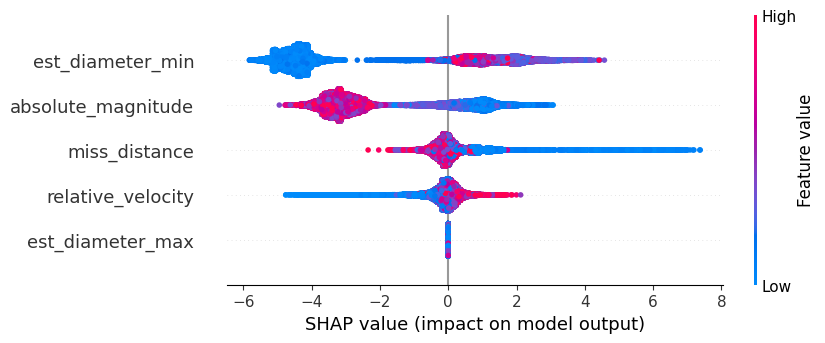

In [ ]:
X_train_best = study.best_trial.user_attrs['X_train']
X_test_best = study.best_trial.user_attrs['X_test']
Y_train_best = study.best_trial.user_attrs['Y_train']
Y_test_best = study.best_trial.user_attrs['Y_test']

explanation = explainer(X_test_best)
shap.plots.beeswarm(explanation)